In [1]:
import datetime
import json
import boto3
import io
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
#import seaborn as sns
plt.style.use('ggplot')

In [2]:
pickle_file = '../btc-autotrader/lib/data/log/2019-04-16T07:22:08.829439.pickle'

In [3]:
df = pd.read_pickle(pickle_file)

In [4]:
df.head()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,ask_low,mid_price,bought_price,sold_price,target_price,size
0,2019-04-16 07:22:14.440037,33744.0,0,0.004901,563590.0,0,None,0,None,563590.0,564029.0,563809.0,0,0,0,0
0,2019-04-16 07:22:19.461740,33744.0,0,0.004901,563590.0,0,-1.84984,0,None,563590.0,564027.0,563808.0,0,0,0,0
0,2019-04-16 07:22:24.487826,33744.0,0,0.004901,563590.0,0,-1.84984,0,0,563589.0,564017.0,563803.0,0,0,0,0
0,2019-04-16 07:22:29.512085,33744.0,0,0.004901,563589.0,0,-2.19618,0,-0.068821,563587.0,564012.0,563799.0,0,0,0,0
0,2019-04-16 07:22:34.538769,33744.0,0,0.004901,563589.0,0,-2.29819,0,-0.0203052,563587.0,563890.0,563738.0,0,0,0,0


In [5]:
df['spread'] = df.ask_low - df.bid_high

In [6]:
df['spread_pct_change'] = df.spread.pct_change()

In [7]:
df.loc[df.rate_of_change >= 0, 'rate_of_change_positive'] = 1
df.loc[df.rate_of_change < 0, 'rate_of_change_positive'] = -1
df.loc[df.rate_of_change >= 5, 'rate_of_change_positive'] = 2
df.loc[df.rate_of_change < -5, 'rate_of_change_positive'] = -2

In [8]:
df['btc_current_price_normalized'] = (df.btc_current_price - df.btc_current_price.mean()) / df.btc_current_price.std()


In [9]:
df['returns'] = np.log(df['btc_current_price']/df['btc_current_price'].shift(1))

In [10]:
df['strategy'] = df['rate_of_change_positive'].shift(1) * df['returns']

In [11]:
df.tail()

,datetime,cash,cash_orig,btc_in_possession,btc_current_price,position,rate_of_change,total_value,acceleration,bid_high,...,bought_price,sold_price,target_price,size,spread,spread_pct_change,rate_of_change_positive,btc_current_price_normalized,returns,strategy
0,2019-04-16 07:38:03.752271,28087.0,0,0.004849,565191.0,3,-1.64264,0,-0.0441376,565241.0,...,565868,565205,0,0,526.0,0.398936,-1.0,0.449092,-0.000327,0.000327
0,2019-04-16 07:38:08.782606,28087.0,0,0.014863,565191.0,3,-1.40697,0,0.0467944,565125.0,...,565868,565205,0,0,375.0,-0.287072,-1.0,0.449092,0.000000,-0.000000
0,2019-04-16 07:38:13.808332,28087.0,0,0.004849,565191.0,3,-1.40697,0,0,565165.0,...,565868,565205,0,0,332.0,-0.114667,-1.0,0.449092,0.000000,-0.000000
0,2019-04-16 07:38:18.833788,28087.0,0,0.014863,565191.0,3,-1.40697,0,0,565146.0,...,565868,565205,0,0,249.0,-0.250000,-1.0,0.449092,0.000000,-0.000000
0,2019-04-16 07:38:23.847491,28087.0,0,0.004849,565191.0,3,-1.40697,0,0,565146.0,...,565868,565205,0,0,34.0,-0.863454,-1.0,0.449092,0.000000,-0.000000


In [12]:
np.exp(df[['returns', 'strategy']].sum())

returns     1.002841
strategy    0.994461
dtype: float64

/Users/sishida/.pyenv/versions/3.7.1/envs/finance-stats/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


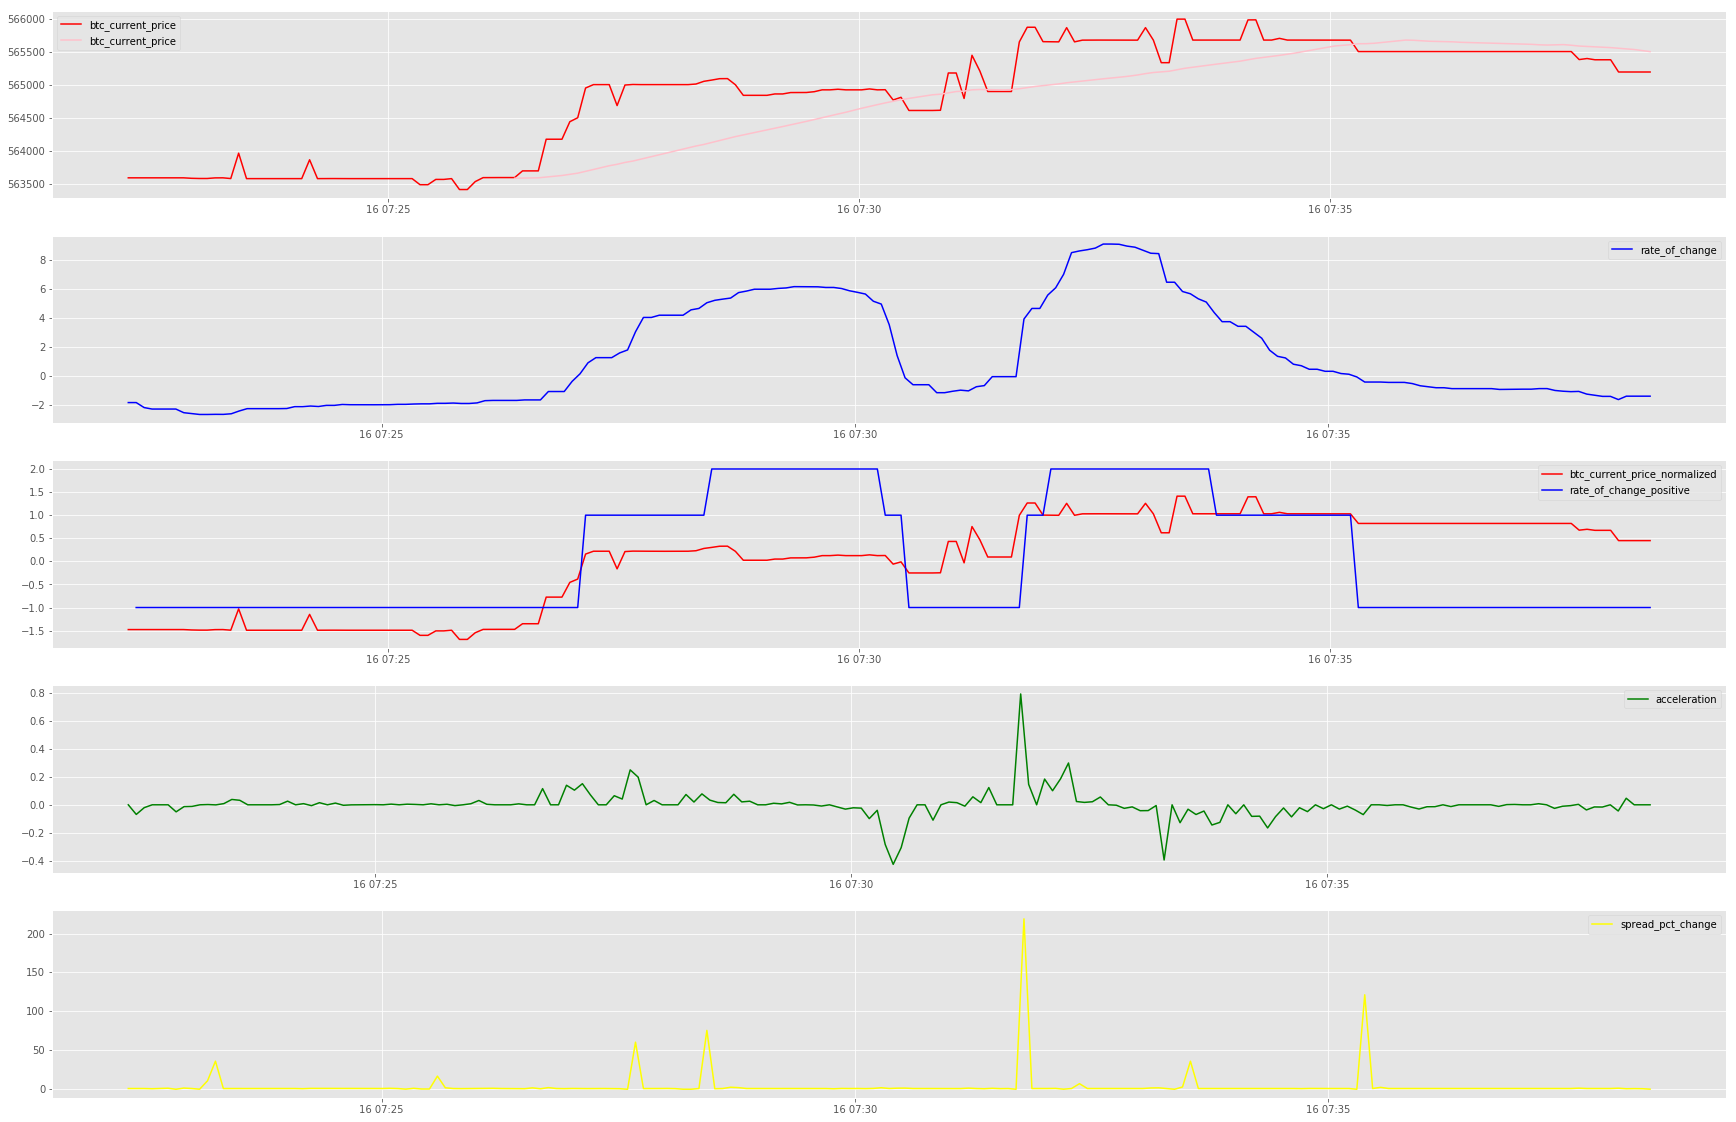

In [13]:
num = 5
fig, axes = plt.subplots(nrows=num, ncols=1, figsize=(30, 20), sharex=True)
plt.subplot(num,1,1)
plt.plot(df.datetime, df.btc_current_price, color='r')
plt.plot(df.datetime, df.btc_current_price.rolling(50).mean(), color='pink')
plt.legend()
#ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
#ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
plt.subplot(num,1,2)
plt.plot(df.datetime, df.rate_of_change, color='b')
plt.legend()
plt.subplot(num,1,3)
plt.plot(df.datetime, df.btc_current_price_normalized, color='r')
plt.plot(df.datetime, df.rate_of_change_positive, color='b')
plt.legend()
plt.subplot(num,1,4)
plt.plot(df.datetime, df.acceleration, color='g')
#plt.yscale('log')
plt.legend()
plt.subplot(num,1,5)
plt.plot(df.datetime, df.spread_pct_change, color='yellow')
plt.legend()
#plt.plot(df.datetime, df.spread_pct_change())
plt.show()

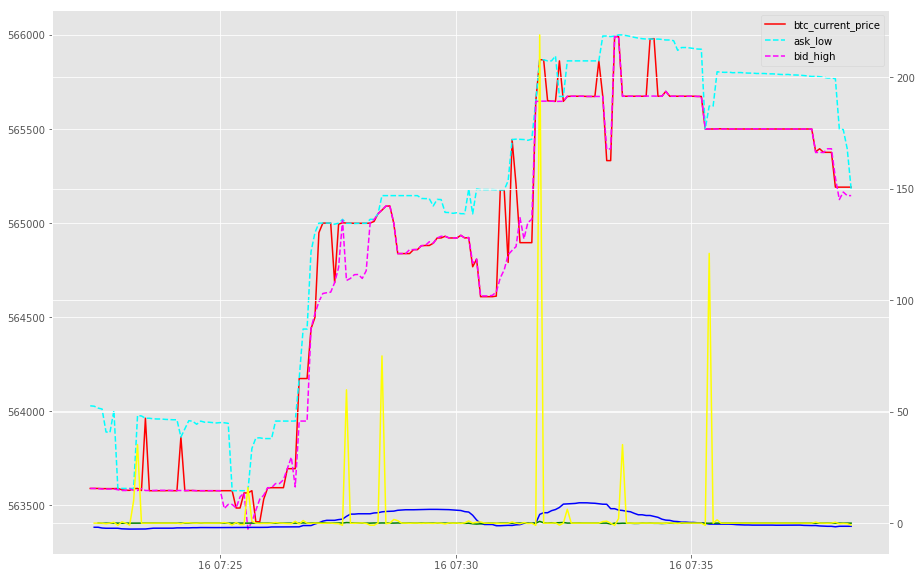

In [14]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.btc_current_price, color='r')
ax1.plot(df.datetime, df.ask_low, color='cyan', linestyle='--')
ax1.plot(df.datetime, df.bid_high, color='magenta', linestyle='--')
ax1.legend()
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
#ax2.legend()
plt.show()

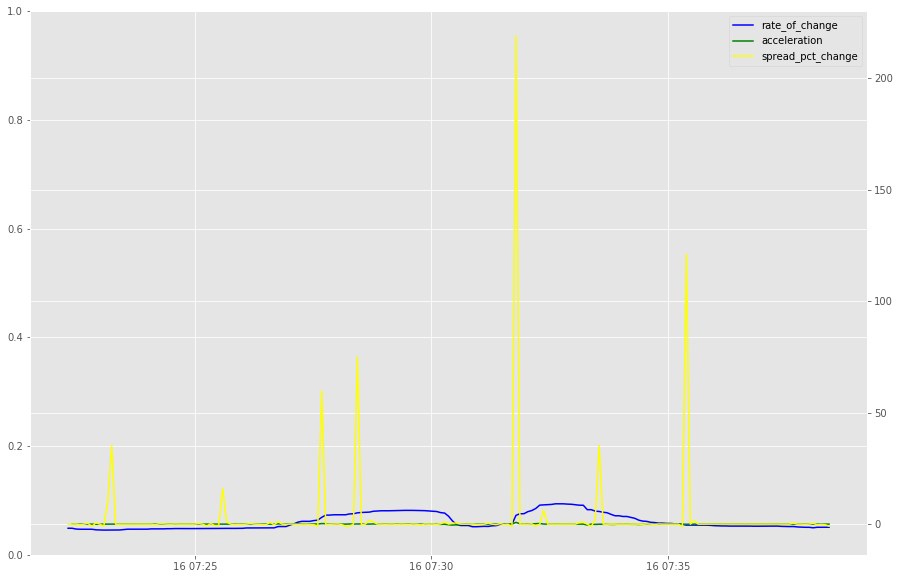

In [15]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
#ax1.plot(df.datetime, df.btc_current_price, color='r')
#ax2.plot(df.datetime, df.spread, color='gray')
#ax1.scatter(df.datetime, df.bid_price, color='black')
ax2.plot(df.datetime, df.rate_of_change, color='b')
ax2.plot(df.datetime, df.acceleration, color='g')
ax2.plot(df.datetime, df.spread_pct_change, color='yellow')
ax2.legend()
plt.show()

In [16]:
df.total_value.iloc[-1] - df.total_value.iloc[0]

0

No handles with labels found to put in legend.


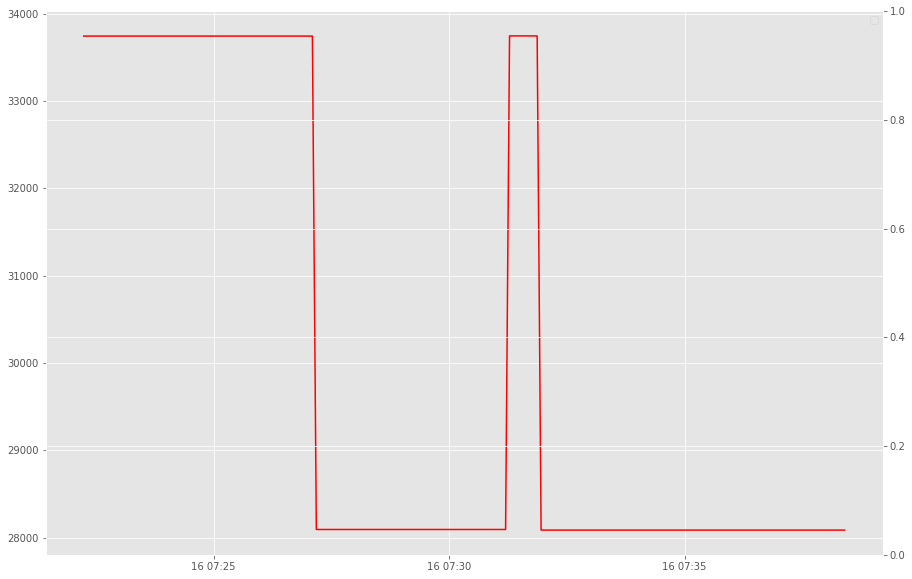

In [17]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
ax1.plot(df.datetime, df.cash, color='r')
#ax2.plot(df.datetime, df.rate_of_change, color='b')
#ax2.plot(df.datetime, df.acceleration, color='g')
ax2.legend()
plt.show()

In [21]:
df.cash.rolling(10).mean()

0        NaN
0        NaN
0        NaN
0        NaN
0        NaN
0        NaN
0        NaN
0        NaN
0        NaN
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
0    33744.0
      ...   
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
0    28087.0
Name: cash, Length: 194, dtype: float64